
## Melanoma Classification
1. [Import and Install Python Libraries](#1)
1. [Import Data](#2)
1. [Exploratory Data Analysis](#3)
1. [Transform and Dataset Prepration](#4)
1. [Resnet](#5)
1. [VGG](#6)
1. [Densenet](#7)
1. [Inception](#8)


<a id='1'></a>
<h1 style='background:midnightblue;padding-top: 20px; border:0; color:red'><center>***Import and Install Python Libraries***</center></h1> 

In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)
# Setup device-agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Using PyTorch version 2.0.0


device(type='cuda')

In [2]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type== 'GPU' ]
print(get_available_gpus())

['/device:GPU:0']


<a id='2'></a>
<h1 style='background:midnightblue;padding-top: 20px; border:0; color:red'><center>***Import Data***</center></h1>


In [3]:
metadata = pd.read_csv(r'/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv(r'/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)

# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,age_approx,anatom_site_general,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,anterior torso,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,anterior torso,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,upper extremity,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,upper extremity,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,posterior torso,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,head/neck,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,anterior torso,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,lower extremity,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,palms/soles,female


In [4]:
diagnosis_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
df['dx'] = df[diagnosis_columns].idxmax(axis=1)
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,age_approx,anatom_site_general,sex,dx
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,anterior torso,female,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,anterior torso,female,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,upper extremity,female,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,upper extremity,male,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,posterior torso,male,MEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,head/neck,female,BCC
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,anterior torso,male,BKL
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,lower extremity,male,MEL
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,palms/soles,female,NV


In [5]:
df = df.drop(columns=diagnosis_columns)

# Apply label encoding to the new diagnosis column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['dx'])
df

,image,age_approx,anatom_site_general,sex,dx,target
0,ISIC_0000000,55.0,anterior torso,female,NV,5
1,ISIC_0000001,30.0,anterior torso,female,NV,5
2,ISIC_0000002,60.0,upper extremity,female,MEL,4
3,ISIC_0000003,30.0,upper extremity,male,NV,5
4,ISIC_0000004,80.0,posterior torso,male,MEL,4
...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,female,BCC,1
25327,ISIC_0073248,65.0,anterior torso,male,BKL,2
25328,ISIC_0073249,70.0,lower extremity,male,MEL,4
25329,ISIC_0073251,55.0,palms/soles,female,NV,5


In [6]:

data = df.loc[:, ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'dx']]
data['image'] = '/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + data['image'] + '.jpg'
data

,image,age_approx,anatom_site_general,sex,target,dx
0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,55.0,anterior torso,female,5,NV
1,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,anterior torso,female,5,NV
2,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,60.0,upper extremity,female,4,MEL
3,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,upper extremity,male,5,NV
4,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,80.0,posterior torso,male,4,MEL
...,...,...,...,...,...,...
25326,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,85.0,head/neck,female,1,BCC
25327,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,65.0,anterior torso,male,2,BKL
25328,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,70.0,lower extremity,male,4,MEL
25329,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,55.0,palms/soles,female,5,NV


In [7]:
data

,image,age_approx,anatom_site_general,sex,target,dx
0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,55.0,anterior torso,female,5,NV
1,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,anterior torso,female,5,NV
2,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,60.0,upper extremity,female,4,MEL
3,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,upper extremity,male,5,NV
4,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,80.0,posterior torso,male,4,MEL
...,...,...,...,...,...,...
25326,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,85.0,head/neck,female,1,BCC
25327,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,65.0,anterior torso,male,2,BKL
25328,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,70.0,lower extremity,male,4,MEL
25329,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,55.0,palms/soles,female,5,NV


<a id='3'></a>
<h1 style='background:midnightblue;padding-top: 20px; border:0; color:red'><center>***Exploratory Data Analysis***</center></h1>


# check for nulls and types

In [8]:
# def plot_distribution(dataframe, target_column):
#     # Calculate value counts and sort them
#     value_counts = dataframe[target_column].value_counts().sort_index()

#     # Create a figure with two subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Bar plot on the first subplot
#     bar_width = 0.35
#     ind = np.arange(len(value_counts))
#     rects = ax1.bar(ind, value_counts.values, width=bar_width, color='midnightblue')
#     ax1.set_xlabel(target_column, fontsize=12)
#     ax1.set_ylabel('Count', fontsize=12)
#     ax1.set_xticks(ind)
#     ax1.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)

#     # Add values on top of bars
#     for index, value in enumerate(value_counts.values):
#         ax1.text(index, value + 0.1, str(value), ha='center', fontsize=10)

#     # Pie plot 
#     explode = [0.1 for i in range(len(value_counts))]
#     patches, texts, autotexts = ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=["blue","midnightblue"], explode=explode, startangle=140)

#     # Adjust the distance of the labels from the center
#     for text in texts:
#         text.set_color('black')
#         text.set_fontsize(10)
#     for autotext in autotexts:
#         autotext.set_fontsize(10)
#         autotext.set_color('white')
#     # Main title for the figure
#     fig.suptitle(f'Distribution in {target_column} column', fontsize=18)
    
#     # Adjust layout and display the figure
#     plt.tight_layout()
#     plt.show()
    
# for column in data.columns:
#     if column == 'image':
#         continue
#     plot_distribution(df, column)

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
data['age_approx'] = data['age_approx'].fillna(data['age_approx'].mean())
scaler = MinMaxScaler()
data['age_scaled'] = scaler.fit_transform(data[['age_approx']])

# Encode the sex column with LabelEncoder
label_encoder_sex = LabelEncoder()
data['sex_encoded'] = label_encoder_sex.fit_transform(data['sex'])

# Encode the localization column with LabelEncoder
label_encoder_localization = LabelEncoder()
data['localization_encoded'] = label_encoder_localization.fit_transform(data['anatom_site_general'])
data

,image,age_approx,anatom_site_general,sex,target,dx,age_scaled,sex_encoded,localization_encoded
0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,55.0,anterior torso,female,5,NV,0.647059,0,0
1,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,anterior torso,female,5,NV,0.352941,0,0
2,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,60.0,upper extremity,female,4,MEL,0.705882,0,7
3,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,upper extremity,male,5,NV,0.352941,1,7
4,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,80.0,posterior torso,male,4,MEL,0.941176,1,6
...,...,...,...,...,...,...,...,...,...
25326,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,85.0,head/neck,female,1,BCC,1.000000,0,1
25327,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,65.0,anterior torso,male,2,BKL,0.764706,1,0
25328,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,70.0,lower extremity,male,4,MEL,0.823529,1,3
25329,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,55.0,palms/soles,female,5,NV,0.647059,0,5


In [10]:
combined_data = data

In [11]:
# train_data, test_data = train_test_split(combined_data_NoC, test_size=0.3, stratify=combined_data_NoC['target'], random_state=42)
# valid_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['target'], random_state=42)

In [12]:
# from PIL import Image
# import matplotlib.pyplot as plt

# # Define the file path of the image you want to display
# image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011.jpg'

# # Open the image using PIL
# image = Image.open(image_path)

# # Display the image using matplotlib
# plt.figure()
# plt.imshow(image)
# plt.axis('off')  # Turn off the axis
# plt.show()

# train_data

<a id='4'></a>
<h1 style='background:midnightblue;padding-top: 20px; border:0; color:red'><center>***Transform and Dataset Prepration***</center></h1>


In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation sets, stratifying by the 'target' column (which contains the encoded labels)
train_df, val_df = train_test_split(combined_data, test_size=0.2, stratify=combined_data['target'], random_state=42)

# Add a 'Position' column to indicate whether the data point is for training or validation
train_df['Position'] = 'train'
val_df['Position'] = 'val'

# Combine the datasets back into one dataframe for the data generator to use
combined_data = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

In [14]:
combined_data

,image,age_approx,anatom_site_general,sex,target,dx,age_scaled,sex_encoded,localization_encoded,Position
0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,40.0,lower extremity,female,5,NV,0.470588,0,3,train
1,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,70.0,upper extremity,female,4,MEL,0.823529,0,7,train
2,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,45.0,anterior torso,female,5,NV,0.529412,0,0,train
3,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,60.0,anterior torso,male,4,MEL,0.705882,1,0,train
4,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,30.0,head/neck,male,1,BCC,0.352941,1,1,train
...,...,...,...,...,...,...,...,...,...,...
25326,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,65.0,posterior torso,male,4,MEL,0.764706,1,6,val
25327,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,60.0,head/neck,male,0,AK,0.705882,1,1,val
25328,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,35.0,lower extremity,female,5,NV,0.411765,0,3,val
25329,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,65.0,upper extremity,male,5,NV,0.764706,1,7,val


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
import os
#import albumentations as A
import matplotlib.pyplot as plt

metadata = combined_data
# Function to apply albumentations transformations
def augment_image(images):
    #image = (image * 255).astype(np.uint8)  # Convert to uint8
    res = albu_transforms_train(image=images)
    image = res['image'].astype(np.float32)  # Convert back to float32 and rescale
    return image
def scale_image(image):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image
# Image preprocessing
train_image_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    #preprocessing_function = data_augment_cutout)
    rescale=1./255)

val_image_datagen = ImageDataGenerator(rescale=1./255)
label_encoder = LabelEncoder()
#metadata['target'] = label_encoder.fit_transform(metadata['dx'])  

class CustomSkinCancerDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, image_datagen, shuffle= False, is_training=False):
        self.df = df
        self.batch_size = batch_size
        self.image_datagen = image_datagen
        self.indices = np.arange(len(self.df))
        self.is_training = is_training
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_image(self, image_id, dx):
        img = Image.open(image_id)
        img = img.resize((224, 224))
        return img

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.df.iloc[i] for i in batch_indices]

        images = []
        ages = []
        sexes = []
        localizations = []
        labels = []
        imageid = []

        for row in batch_data:
            image_id = row['image']
            img = self._get_image(image_id, row['dx'])
            img_array = np.array(img) 
            if self.is_training:
                #res = albu_transforms_train(image=img_array)
                res = data_augment(img_array)
                img = scale_image(res)
                #img = self.image_datagen.random_transform(img)
            else:
                img = img_array

            age, sex, localization = row['age_scaled'], row['sex_encoded'], row['localization_encoded']
            
            imageid.append(image_id)
            images.append(img)
            ages.append(np.array([age]))
            sexes.append(sex)
            localizations.append(localization)
            labels.append(row['target'])

        #return np.array(images), np.array(labels)
        return [np.array(images), np.array(ages), np.array(sexes), np.array(localizations)], np.array(labels)

    def get_labels(self):
        return self.df['dx'].values

# Create datasets

train_dataset = CustomSkinCancerDataset(metadata[metadata['Position'] == 'train'], batch_size=16, image_datagen=train_image_datagen, is_training=False, shuffle= True)
val_dataset = CustomSkinCancerDataset(metadata[metadata['Position'] == 'val'], batch_size=16, image_datagen=val_image_datagen, is_training=False)




(16, 224, 224, 3)


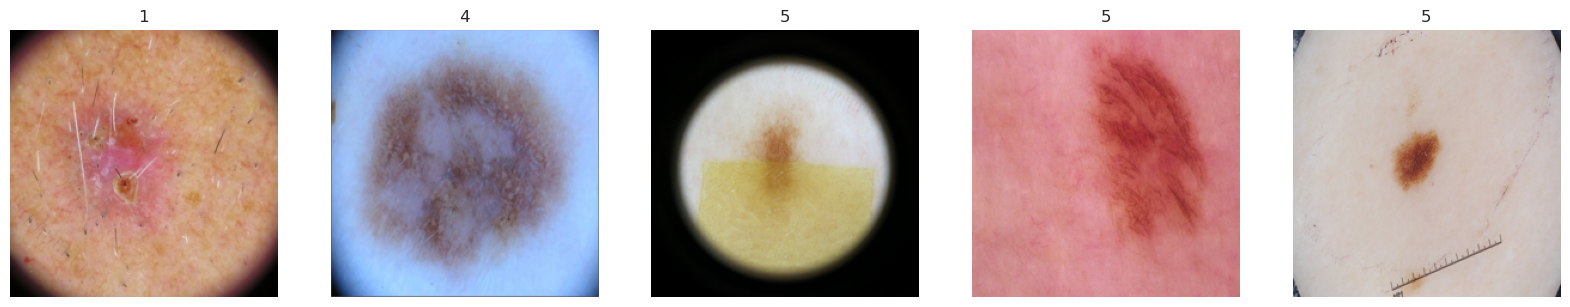

In [16]:
import random
# Function to plot images with metadata in title
def plot_images_with_metadata(dataset, num_images=5):
    for X, y in dataset:
        images, ages, sexes, localizations = X[0], X[1], X[2], X[3]
        print(images.shape)
        #images = X
        #label = y
        break
    
    fig, axes = plt.subplots(1,num_images, figsize=(20, 5))
    for i in range(num_images):
        j = random.randint(1,15)
        ax = axes[i]
        ax.imshow(images[j])
#         age = ages[i][0]
#         sex = 'Male' if sexes[i][0] == 0 else 'Female'
#         localization = list(localization_to_index.keys())[np.argmax(localizations[i])]
#         ax.set_title(f'Age: {age}, Sex: {sex}, Loc: {localization}')

        ax.set_title(f'{y[j]}')
        ax.axis('off')
    plt.show()

# Example usage
plot_images_with_metadata(train_dataset, num_images=5)

(16, 224, 224, 3)


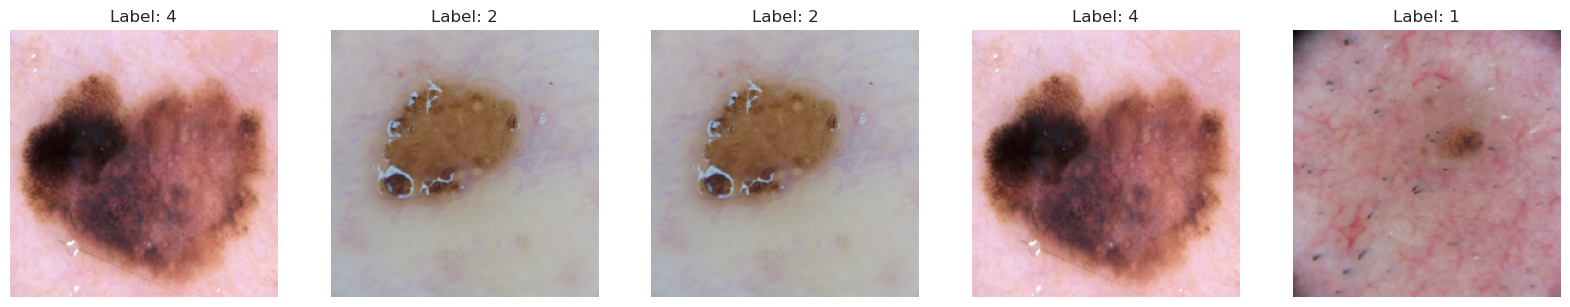

In [17]:
import random
# Function to plot images with metadata in title
def plot_images_with_metadata(dataset, num_images=5):
    for X, y in dataset:
        images, ages, sexes, localizations = X[0], X[1], X[2], X[3]
        print(images.shape)
        #images = X
        #label = y
        break
    
    fig, axes = plt.subplots(1,num_images, figsize=(20, 5))
    for i in range(num_images):
        j = random.randint(1,15)
        ax = axes[i]
        ax.imshow(images[j])
#         age = ages[i][0]
#         sex = 'Male' if sexes[i][0] == 0 else 'Female'
#         localization = list(localization_to_index.keys())[np.argmax(localizations[i])]
#         ax.set_title(f'Age: {age}, Sex: {sex}, Loc: {localization}')
        ax.set_title(f'Label: {y[j]}')
        ax.axis('off')
    plt.show()

# Example usage
plot_images_with_metadata(val_dataset, num_images=5)

<a id='5'></a>
<h1 style='background:midnightblue;padding-top: 20px; border:0; color:red'><center>***Resnet***</center></h1>>


In [18]:
#! /opt/conda/bin/python3.7 -m pip install -q --upgrade pip
! pip install -q efficientnet

In [19]:
import tensorflow as tf
DEVICE = 'TPU'
if DEVICE == 'TPU':
    print('connecting to TPU...')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None

    if tpu:
        try:
            print('Initializing  TPU...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print('TPU initialized')
        except _:
            print('Failed to initialize TPU!')
    else:
        DEVICE = 'GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    print('Num GPUs Available: ',
          len(tf.config.experimental.list_physical_devices('GPU')))
REPLICAS = strategy.num_replicas_in_sync
print('REPLICAS: ', strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS:  1


In [20]:
cfg = dict(
           lr_start=0.000005,
           lr_max=0.00000125,
           lr_min=0.000001,
           lr_rampup=5,
           lr_sustain=0,
           lr_decay=0.8,
           epochs=12,
           batch_size=16,
           transform_prob=1.0,
           rot=180.0,
           shr=2.0,
           hzoom=8.0,
           wzoom=8.0,
           hshift=8.0,
           wshift=8.0,

           optimizer='adam',
           label_smooth_fac=0.05,
           tta_steps=20

        )

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dense, Dropout, Multiply, Lambda,
                                     concatenate)
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import numpy as np

# Define the attention block
def attention_block(inputs, name):
    attention_probs = Dense(inputs.shape[-1], activation='softmax', name=name+'_attention')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

# Define the complex belief mass function
def complex_belief_mass_function(features, num_classes, name):
    x = Dense(128, activation='relu')(features)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Apply attention mechanism
    x = attention_block(x, name=name+'_attention')
    
    belief_masses = Dense(num_classes, activation='softmax', name=name+'_belief')(x)  # Ensure belief masses sum to 1
    return belief_masses

# Updated Dempster-Shafer function with evidence discounting
def apply_dempster_shafer_discounted(belief1, belief2, alpha1=0.9, alpha2=0.8):
    # Adjust the belief masses based on reliability
    belief1 = K.clip(belief1, K.epsilon(), 1 - K.epsilon())
    belief2 = K.clip(belief2, K.epsilon(), 1 - K.epsilon())

    # Discount the belief masses
    belief1_discounted = alpha1 * belief1
    belief2_discounted = alpha2 * belief2

    # Assign the remaining mass to uncertainty (distributed equally)
    num_classes = K.shape(belief1)[-1]
    uncertainty1 = (1 - alpha1) * (1.0 / K.cast(num_classes, K.floatx()))
    uncertainty2 = (1 - alpha2) * (1.0 / K.cast(num_classes, K.floatx()))

    # Adjusted belief masses including uncertainty
    belief1_adjusted = belief1_discounted + uncertainty1
    belief2_adjusted = belief2_discounted + uncertainty2

    # Combine the belief masses using Dempster's Rule of Combination
    numerator = belief1_adjusted * belief2_adjusted
    denominator = K.sum(numerator, axis=-1, keepdims=True)
    combined_belief = numerator / (denominator + K.epsilon())

    # Normalize to ensure the belief masses sum to 1
    combined_belief = combined_belief / K.sum(combined_belief, axis=-1, keepdims=True)
    return combined_belief

# Begin defining the model
# Assuming you have a strategy scope for distributed training
# Remove or modify 'strategy.scope()' if not using distributed training
strategy = tf.distribute.get_strategy()
with strategy.scope():
    input_shape = (224, 224, 3)
    num_classes = 9

    # Load the EfficientNet base model
    base = efn.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = True  # Set to False if you want to freeze the base model layers

    # Inputs
    image_input = Input(shape=input_shape, name='image_input')
    age_input = Input(shape=(1,), name='age_input')
    sex_input = Input(shape=(1,), name='sex_input')
    localization_input = Input(shape=(1,), name='localization_input')

    # EfficientNet feature extraction
    # Get the output up to the desired layer
    insert_layer_name = 'block1a_dwconv'
    insert_layer_index = [idx for idx, layer in enumerate(base.layers) if layer.name == insert_layer_name][0]

    # Create partial model up to the insertion layer
    partial_base_model = keras.Model(inputs=base.input, outputs=base.layers[insert_layer_index].output, name='PartialEfficientNet')
    existing_tensor = partial_base_model(image_input)

    # Continue with the rest of the model after the insertion point
    rest_of_model_input = base.layers[insert_layer_index + 1].input
    rest_of_model_output = base.output
    rest_of_model = keras.Model(inputs=rest_of_model_input, outputs=rest_of_model_output, name='RestOfEfficientNet')

    # Pass the existing tensor through the rest of the model
    output = rest_of_model(existing_tensor)

    # Convert image features to belief masses
    image_belief = complex_belief_mass_function(output, num_classes, name='image')

    # Tabular data processing
    tabular_input = concatenate([age_input, sex_input, localization_input])
    y = Dense(256, activation='relu')(tabular_input)
    y = Dropout(0.5)(y)

    # Convert tabular features to belief masses
    tabular_belief = complex_belief_mass_function(y, num_classes, name='tabular')

    # Combine belief masses using the improved Dempster-Shafer function
    combined_belief = Lambda(lambda tensors: apply_dempster_shafer_discounted(
        tensors[0], tensors[1], alpha1=0.9, alpha2=0.8))([image_belief, tabular_belief])

#     # Concatenate features and combined belief
    combined_features = concatenate([output, y, combined_belief])
    combined = Dense(512, activation='relu')(output)
    combined = Dropout(0.5)(combined)
    combined = Dense(256, activation='relu')(combined)
    combined_output = Dense(num_classes, activation='softmax')(combined)  # Adjust the number of units based on your task

    # Create the final model 
    model = keras.Model(inputs=[image_input, age_input, sex_input, localization_input],
                        outputs=combined_output,
                        name='CustomModel')

# Print the model summary
model.summary()


16804768/16804768 [==============================] - 0s 0us/step
Model: "CustomModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 PartialEfficientNet (Functiona  (None, 112, 112, 32  1280       ['image_input[0][0]']            
 l)                             )                                                                 
                                                                                                  
 RestOfEfficientNet (Functional  (None, 1280)        4048284     ['PartialEfficientNet[0][0]']    
 )                     

In [22]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
def compileNewModel():

    ''' Configuring the model with losses and metrics. '''

    with strategy.scope():
        models = model

    with strategy.scope():

        optimizer = 'adam'
        model.compile(optimizer= optimizer, 
                                   loss=[SparseCategoricalCrossentropy()],
                                   metrics=[SparseCategoricalAccuracy()])
        #tf.keras.metrics.AUC(name='auc')
    #print(models.summary())
    return models

def getLearnRateCallback(cfg):

    ''' Using callbacks for learning rate adjustments. '''
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


def learnModel(model, ds_train, cfg, ds_val, nepochs):

    ''' Fitting things together for training '''

    filepath1 = "Efficient_att_isic2019.weights.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_sparse_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [checkpoint, getLearnRateCallback(cfg)]
    #get_lr_callback()

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        batch_size= 32,
                        verbose=True,
                        epochs=nepochs,
                        callbacks=callbacks)

    return history

In [23]:
#with fusion
#07/10 with best hyperparameters
#1266/1266 [==============================] - ETA: 0s - loss: 1.5221 - sparse_categorical_accuracy: 0.4936
# 1: val_sparse_categorical_accuracy improved from -inf to 0.57041, saving model to Efficient_att_isic2019.weights.h5
import efficientnet.tfkeras as efn
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,Activation,MaxPooling2D,Flatten,Dense,Dropout,Input,Reshape,Lambda
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
model = compileNewModel()
history = learnModel(model, train_dataset, cfg, val_dataset, 90)

Epoch 1/90


2024-10-09 22:22:22.200845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inCustomModel/RestOfEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1266/1266 [==============================] - ETA: 0s - loss: 1.5401 - sparse_categorical_accuracy: 0.4600
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.56784, saving model to Efficient_att_isic2019.weights.h5
1266/1266 [==============================] - 715s 527ms/step - loss: 1.5401 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.2371 - val_sparse_categorical_accuracy: 0.5678 - lr: 5.0000e-06
Epoch 2/90
1266/1266 [==============================] - ETA: 0s - loss: 1.1633 - sparse_categorical_accuracy: 0.6005
Epoch 2: val_sparse_categorical_accuracy improved from 0.56784 to 0.64537, saving model to Efficient_att_isic2019.weights.h5
1266/1266 [==============================] - 425s 336ms/step - loss: 1.1633 - sparse_categorical_accuracy: 0.6005 - val_loss: 1.0452 - val_sparse_categorical_accuracy: 0.6454 - lr: 8.0000e-06
Epoch 3/90
1266/1266 [==============================] - ETA: 0s - loss: 1.0295 - sparse_categorical_accuracy: 0.6427
Epoch 3: val_sparse_categoric

In [24]:
model.load_weights('/kaggle/working/Efficient_att_isic2019.weights.h5')

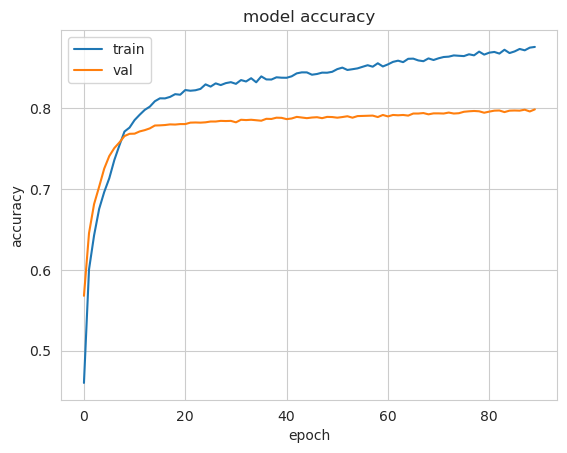

In [25]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

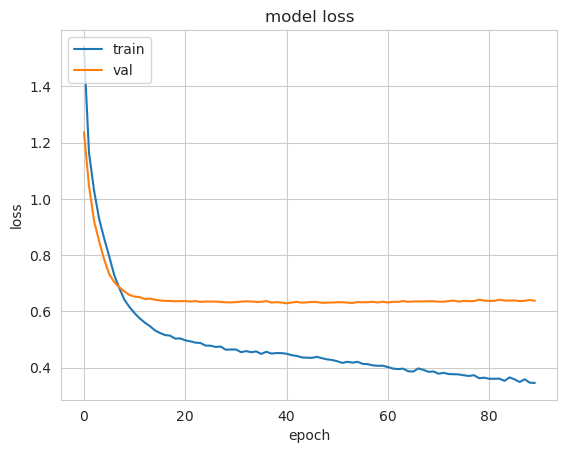

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

def metrics(model, val_dataset):
    # Extract true labels from validation dataset
    #y_true = val_dataset.get_labels()
    # Get predictions from the model
    y_true = []
    for _, labels in val_dataset:
        y_true.extend(labels)
    y_true = np.array(y_true)
    predictions = model.predict(val_dataset, steps=len(val_dataset), verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_prob = predictions

    # Convert true labels to categorical for ROC AUC calculation
    y_test = to_categorical(y_true, num_classes=7)

    targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    
    # Creating classification report
    report = classification_report(y_true, y_pred, target_names=targetnames)
    print("Classification Report:")
    print(report)

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    print("weighted Roc score: " + str(roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')))

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    print("Macro Roc score: " + str(roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')))

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    tpr = {}
    fpr = {}
    roc_auc = {}
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("Micro Roc score: " + str(roc_auc["micro"]))
    

    print('---------------------------------------------------------------------------------------')
    for i in range(7):
        r = roc_auc_score(y_test[:, i], y_prob[:, i])
        print("The ROC AUC score of "+targetnames[i]+" is:" + str(r))

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(15,10))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'yellow', 'red', 'blue']
    for i, color in zip(range(7), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{0} (area = {1:0.2f})'.format(targetnames[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

    return predictions

In [28]:
y_true = []
for _, labels in val_dataset:
    y_true.extend(labels)
y_true = np.array(y_true)

In [29]:
# Example usage
predictions = metrics(model, val_dataset)

IndexError: index 7 is out of bounds for axis 1 with size 7

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
#cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

In [ ]:
import itertools

test_labels = y_true
# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels,normalize=True, title='Confusion Matrix')